<a href="https://colab.research.google.com/github/KarlaLutz/Trabalho_CNN_Turma9_BigData_FGV/blob/main/Trabalho_CNN_XRays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Instalando Bibliotecas e Preparando o Ambiente do Dataset**

In [83]:
# Para a execução do ExplanabeAI posteriormente

%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [84]:
pip install shap

In [85]:
pip list | grep tensorflow

tensorflow                    2.6.0
tensorflow-datasets           4.0.1
tensorflow-estimator          2.6.0
tensorflow-gcs-config         2.6.0
tensorflow-hub                0.12.0
tensorflow-metadata           1.2.0
tensorflow-probability        0.14.1


In [48]:
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from glob import glob
import numpy as np
import seaborn as sns
import cv2
import pandas as pd
import os

In [49]:
# Motando google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [50]:
# Professor, nesse step, antes de rodar o código, favor acessar o seguinte drive: https://drive.google.com/drive/folders/1XcG4umqBU37TE1E5bQHuW1zVCKM2GXaB?usp=sharing
  # E criar um atalho da pasta Xrays para o seu drive (Add Shortcut To Drive), dessa forma terá acesso às imagens que utilizamos.

# Nesta etapa estamos categorizando as imagens em imagens de pulmões com Pneumonia e Normal.
# Criamos um loop para rodar no nosso database de imagens de Raio-X e baseado no label de cada imagem, categorizamos como tal.

labels = ['PNEUMONIA','NORMAL']
img_size = 150
def recupera_dados_drive(data_dir):
    data = [] 
    for label in labels: 
      for path in glob(os.path.join(data_dir, label+'*')): 
        class_num = labels.index(label)
        for img in os.listdir(path):            
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [51]:
# Separando o Dataset já categorizado nas bases de treino, teste e validação;
# Com a base de treino, iremos pegar cerca de 70% das imagens onde utilizaremos para ensinar nosso modelo;
# Com a base de validação nós iremos realizar um tipo de doublecheck naquilo que nosso modelo foi capaz de aprender da etapa anterior;
# Finalmente, com a base de teste, iremos testar se o modelo está acertando ou errando.

train = recupera_dados_drive('/content/drive/MyDrive/Xrays/Train/')
test = recupera_dados_drive('/content/drive/MyDrive/Xrays/Test/')
val = recupera_dados_drive('/content/drive/MyDrive/Xrays/Validation/')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


# **Visualização e Limpeza dos Dados**

Text(0.5, 1.0, 'NORMAL')

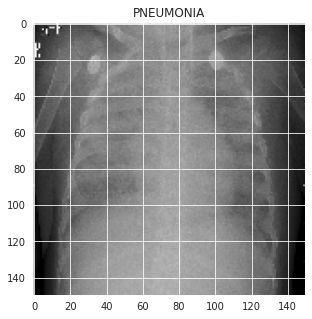

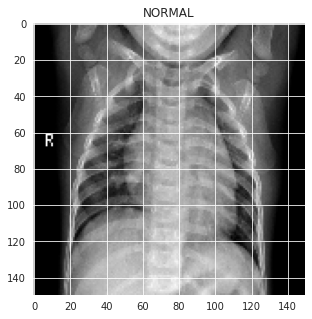

In [71]:
# Vamos plotar uma imagem de exemplo de cada categoria apenas para uma verificação simples.

plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [53]:
# Separando as features da variável resposta dos datasets de treino, validação e teste

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [54]:
# Neste ponto iremos normalizar os dados. Como a escala de cores chega até o número 255, vamos simplificar isso alterando para 0s e 1s, assim nosso modelo conseguirá ler os dados propriamente

x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [55]:
# Vamos agora remodelar nossas matrizes dos três datasets para um vetor de forma que nossos dados não sejam alterados
# Como a dimensão dessa matriz é desconhecida, passaremos o parâmetro -1 para que o numpy descubra observando o comprimento da matriz e suas dimensões restantes
# Dessa forma se certificando de que atende aos critérios mencionados acima

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# **Data Augmentation**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


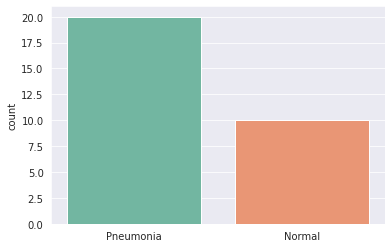

In [56]:
# Vamos analisar como está a distribuição dos nossos dados em relação as categorizações feitas no dataset de treino.
# Podemos notar que temos muito mais imagens de Raios-X com Pneumonia do que Normais, por isso utilizaremos da técnica de Data Augmentation para nivelar essa diferença.

imagens = []
for i in train:
    if(i[1] == 0):
        imagens.append("Pneumonia")
    else:
        imagens.append("Normal")
sns.set_style('darkgrid')
sns.countplot(imagens, palette = "Set2")   

In [60]:
# Como pudemos observar anteriormente temos um desbalanceamento no dataset de treino.
# Para nivelar essa diferença utilizaremos de métodos como rotação, zoom, alterações verticais/horizontais e espelhamento para criar novas imagens a partir daquelas já existentes.

datagen = ImageDataGenerator(
  rotation_range = 47,  # Rotacionando a imagem em 47 graus
  width_shift_range = 0.15,  # Alterando a imagem na horizontal em 15%
  height_shift_range = 0.15,  # Alterando a imagem na vertical em 15%
  horizontal_flip = True,  # Espelhando na horizontal
  vertical_flip = True,  # Espelhando na vertical
  zoom_range = 0.30) # Aplicando um zoom de 30%  

datagen.fit(x_train)

# **Treinando o Modelo**

In [62]:
# Iniciaremos o treino do nosso modelo utilizando XX neuronios.
# Aplicaresmos um padrão na forma das imagens de 150 x 150, a função de ativação dos neuronios intermediários será relu e a do último aplicaremos o sigmoid.

model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_4 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 38, 38, 64)       

In [63]:
# Ensinando ao modelo

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.3, min_lr=0.000001)

In [64]:
# Validaremos o treino realizado acima no nosso dataset de validação para dar um doublecheck 

history = model.fit(datagen.flow(x_train,y_train, batch_size = 32), epochs = 12 , validation_data = datagen.flow(x_val, y_val), callbacks = [learning_rate_reduction])

Epoch 1/12
1/1 [==============================] - 5s 5s/step - loss: 0.9536 - accuracy: 0.5333 - val_loss: 0.7314 - val_accuracy: 0.3333
Epoch 2/12
1/1 [==============================] - 2s 2s/step - loss: 1.8752 - accuracy: 0.7333 - val_loss: 0.6524 - val_accuracy: 0.6667
Epoch 3/12
1/1 [==============================] - 2s 2s/step - loss: 6.1436 - accuracy: 0.6667 - val_loss: 1.0650 - val_accuracy: 0.3333
Epoch 4/12
1/1 [==============================] - 2s 2s/step - loss: 16.9741 - accuracy: 0.3667 - val_loss: 0.9838 - val_accuracy: 0.3333

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/12
1/1 [==============================] - 2s 2s/step - loss: 1.6631 - accuracy: 0.8000 - val_loss: 0.7586 - val_accuracy: 0.4000
Epoch 6/12
1/1 [==============================] - 2s 2s/step - loss: 0.5690 - accuracy: 0.9000 - val_loss: 0.6333 - val_accuracy: 0.6667

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 7/12
1/1 

In [69]:
print("A perca obtida com o modelo treinado é de" , model.evaluate(x_test,y_test)[0])
print("A acurácia do nosso modelo é de" , model.evaluate(x_test,y_test)[1]*100 , "%")

1/1 [==============================] - 0s 416ms/step - loss: 1.4992 - accuracy: 0.6667
A perca obtida com o modelo treinado é de 1.4992268085479736
1/1 [==============================] - 0s 426ms/step - loss: 1.4992 - accuracy: 0.6667
A acurácia do nosso modelo é de 66.66666865348816 %


# **Analise Gráfica Pós Treinamento**

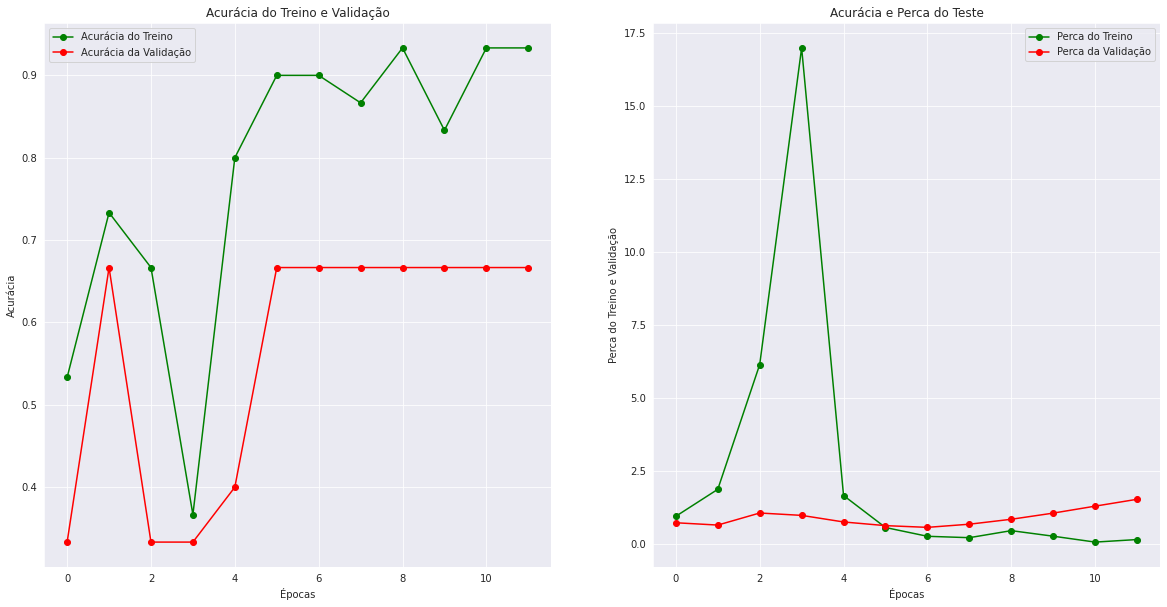

In [75]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Acurácia do Treino')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Acurácia da Validação')
ax[0].set_title('Acurácia do Treino e Validação')
ax[0].legend()
ax[0].set_xlabel("Épocas")
ax[0].set_ylabel("Acurácia")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Perca do Treino')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Perca da Validação')
ax[1].set_title('Acurácia e Perca do Teste')
ax[1].legend()
ax[1].set_xlabel("Épocas")
ax[1].set_ylabel("Perca do Treino e Validação")
plt.show()

In [76]:
# Agora que temos nosso modelo treinado, realizaremos predições de algumas imagens
# O retorno da predição é um array de 10 números. Eles representam um a confiança do modelo que a imagem corresponde a cada um dos raios-X. Podemos ver cada label tem um maior valor de confiança:

predictions = model.predict(x_test)
predictions = np.round(predictions).astype(int)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [77]:
# Abaixo temos o print do valor de precisão, recall, f1-scores e support para cada uma das categorias.
# A precisão fala sobre quão exato é nosso modelo em relação aos positivos previstos, quantos deles são realmente positivos.
# O recall calcula quantos dos positivos reais nosso modelo captura, que foram rotulados como positivo (verdadeiro positivo)
# O F1-score é uma função da precisão e do recall. Ele representa o balanceamento entre a precisão e o recall, como podemos ter uma distribuição de classes desigual, utilizar essa métrica pode ser viável.
# Suporte é o número de ocorrências reais da classe no conjunto de dados especificado. O suporte desequilibrado nos dados de treinamento pode indicar fraquezas estruturais nas pontuações relatadas do classificador e pode indicar a necessidade de amostragem estratificada ou rebalanceamento.


print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.67      1.00      0.80        20
   Normal (Class 1)       0.00      0.00      0.00        10

           accuracy                           0.67        30
          macro avg       0.33      0.50      0.40        30
       weighted avg       0.44      0.67      0.53        30



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
# Matriz de Confusão

cm = confusion_matrix(y_test,predictions)
cm

array([[20,  0],
       [10,  0]])

In [79]:
# Separando o que identificamos como correto e incorreto

correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

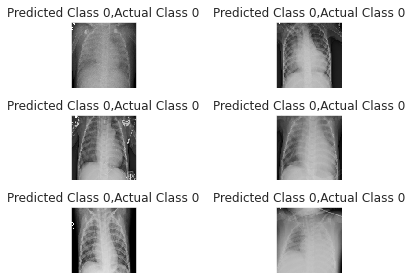

In [80]:
# Alguns exemplos de classificações corretas

i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

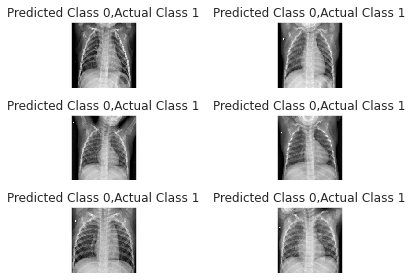

In [81]:
# Alguns exemplos de classificação incorreta

i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

# **ExplanabeAI**

In [89]:
# Criando uma lista de strings com os labels
labels = ["Real Pneumonia" if y else "Real Normal" for y in y_test[50:65]]
labels = pd.DataFrame(labels, columns=["Labels"])

# Realizando predições utilizando numpy
predictions = model.predict(x_test[50:65]).round().reshape(-1, 1).astype(int)
labels["Predictions"] = [
    "Predicted Pneumonia" if y else "Predicted Normal" for y in predictions
]
labels["Print Real - Predicted"] = labels["Labels"].str.cat(
    labels["Predictions"], sep=" - "
)

# Colunas com ambas informações
labels_to_print = labels["Print Real - Predicted"].values.reshape(-1, 1)
labels

ValueError: ignored

In [88]:
import shap

# Criação do explainer object que será usado pelo modelo
e = shap.DeepExplainer(model, x_test)

# Os valores shap são os valores de explicação
shap_values = e.shap_values(x_test[50:65])

# Plot das imagens explicando as predições
shap.image_plot(shap_values, -x_test[50:65], labels_to_print, show=False)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


ValueError: ignored